# Back-Propagation

> Nathaniel Hernandez, Nicholas Malott, Sam Oakes, Iker Santos Perez, Joshua Shell

Implement a classifier using a neural network with the **back-propagation rule** for the data set *‘data_banknote_authentification.txt’* provided on Canvas.   

A full description of the data set is available at https://archive.ics.uci.edu/ml/datasets/banknote+authentication#

Two issues are to be considered as follows:
1. The selection of the squashing function, and
2.  The selection of the number of nodes in the hidden layer.


## 0. Initialization

In [ ]:
import numpy as np 
import matplotlib.pyplot as plt
import matplotlib.gridspec as gridspec
import pandas as pd 
import random
import math
from pprint import pprint
from collections import Counter
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
import warnings

#suppress warnings
warnings.filterwarnings('ignore')

### Data Loading:


In [ ]:
dataset = pd.read_csv('/content/data_banknote_authentication.txt', header=None)
dataset.head(5)

,0,1,2,3,4
0,3.62160,8.6661,-2.8073,-0.44699,0
1,4.54590,8.1674,-2.4586,-1.46210,0
2,3.86600,-2.6383,1.9242,0.10645,0
3,3.45660,9.5228,-4.0112,-3.59440,0
4,0.32924,-4.4552,4.5718,-0.98880,0


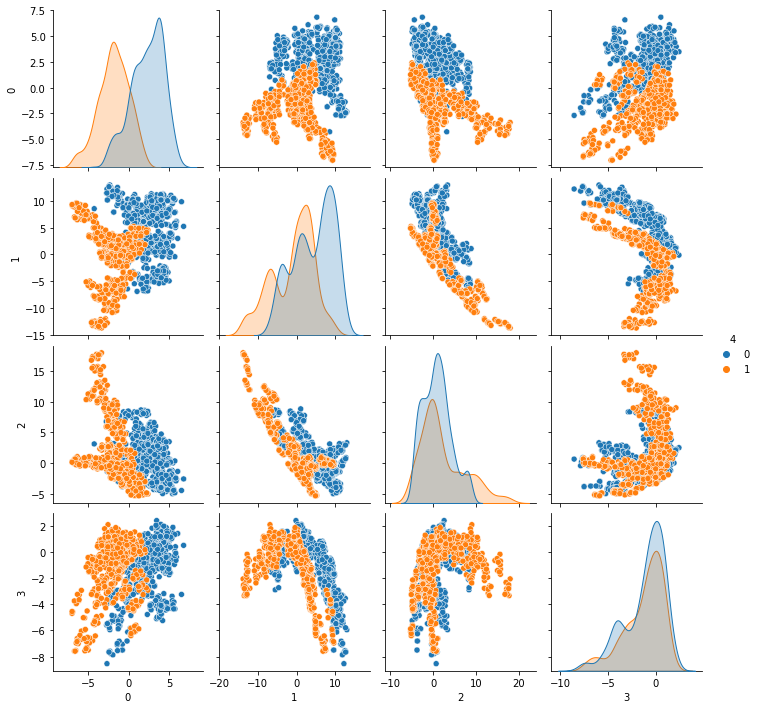

In [ ]:
import seaborn as sns
sns.pairplot(dataset,hue=4)
plt.show()

# 1. NN Backpropagation implementation

[Ref 1](https://machinelearningmastery.com/implement-backpropagation-algorithm-scratch-python/)

[Ref 2](https://stackabuse.com/creating-a-neural-network-from-scratch-in-python-adding-hidden-layers/)

With respect to (1), two squashing functions should be considered:
*  **the sigmoid function:** $σ(x) = 1/(1+ e^{-x})$  whose derivative is 
$x'= σ(x)(1- σ(x))$ 
*  **the hyperbolic tangent:** $tanh (x) = (e^x - e^{-x})/(e^x + e^{-x})$ with derivative is 
$tanh'(x)=1-tanh^2(x)$

In [ ]:
def accuracy(pred, original):
  return np.mean(pred == original)

class generalNN():
  
  #Track what activation function is represented by the NN
  actType = {0:'Sigmoid', 1:'Hyperbolic Tangent'}
  actInt = 0

  #Store hidden layer and output layer weights
  hidNodes = 0
  dim = []
  hidLayerWt = []
  outLayerWt = []


  #Intialize with # hiddenNodes, data dimension, activation type (integer)
  def __init__(self, hiddenNodes, datadim, actInt):
    self.hidNodes = hiddenNodes
    self.dim = datadim
    self.actInt = actInt

    # Initialize hidden and output layer weights randomly
    # np.random.seed(0)
    self.hidLayerWt = np.random.randn(self.hidNodes, self.dim)  #size(num of hidden nodes, number of features = 4)
    self.outLayerWt = np.random.randn(1, self.hidNodes)         #size(num of outputs = 1, num of hidden nodes)
  

  def Sigmoid(self, x):
    return 1 / (1 + np.exp(-x))


  # Call either the sigmoid function or tanh
  def transfer(self, activate):
    if(self.actInt == 0):               # 0: Sigmoid = 1/(1+e^(-x))
      return self.Sigmoid(activate)
    elif(self.actInt == 1):             # 1: Hyperbolic Tangent = (e^x - e^(-x)) / (e^x + e^(-x))
      return np.tanh(activate)


  # Call the derivative of either the sigmoid function or tanh function
  def transfer_derivative(self, activate):
    if(self.actInt == 0):                                               # 0: Derivative Sigmoid = sigmoid * (1 - sigmoid)
      return self.Sigmoid(activate) * (1 - self.Sigmoid(activate))
    elif(self.actInt == 1):                                             # 1: Derivative Hyperbolic Tangent = 1 - tanh^2
      return 1 - np.tanh(activate) ** 2


  # Question is, are we supposed to use sigmoid/tanh for the output, or just the perceptron
  def propagate(self, x, y, rate):
    # Forward Propagation
    ah = self.hidLayerWt.dot(x.T)   # Activate    (hidden nodes, features) dot (features, examples)
    oh = self.transfer(ah)          # Sig or Tanh (hidden nodes, examples)  
    ak = self.outLayerWt.dot(oh)    # Activate    (outputs, hidden nodes) dot (hidden nodes, examples)
    ok = self.transfer(ak)          # Sig or Tanh (outputs, examples)

    # Backwards Propagation
    delk = self.transfer_derivative(ak) * (y - ok)
    delh = self.transfer_derivative(ah) * self.outLayerWt.T.dot(delk)

    # delta weights
    dweightk = np.dot(delk, ah.T)
    dweighth = np.dot(delh, x)

    # Update Weights
    self.outLayerWt += rate * dweightk
    self.hidLayerWt += rate * dweighth

    # Error
    # print(0.5 * np.sum((y - ok) ** 2))


  # Train for some number of epochs
  def train(self, x, y, rate, epochs):
    if self.actInt == 1:
      y[y==0] = -1

    for epoch in range(epochs):
      self.propagate(x, y, rate)
    return

  # predict output and compare to real label
  def accuracy(self, x, y):
    output = np.mean(self.predict(x) == y)
    return output


  def predict(self, x):
    # Forward Propagation
    ah = self.hidLayerWt.dot(x.T)   # Activate    (hidden nodes, features) dot (features, examples)
    oh = self.transfer(ah)          # Sig or Tanh (hidden nodes, examples)  
    ak = self.outLayerWt.dot(oh)    # Activate    (outputs, hidden nodes) dot (hidden nodes, examples)
    ok = self.transfer(ak)          # Sig or Tanh (outputs, examples)

    # Almost forgot this
    if self.actInt == 0:
      ok[ok < 0.5] = 0
      ok[ok >= 0.5] = 1
    else:
      ok[ok < 0] = -1
      ok[ok >= 0] = 1

    return ok

In [ ]:
#### Testing ####

#Params
epochs = 200
learnRate = 0.01

#Format our dataset
x = dataset.drop(columns=4)
x_normed = (x-x.mean())/x.std()
# x_normed = (x-x.min())/(x.max()-x_normed.min())
# x_normed = x.iloc[:,0:4].apply(lambda x: (x-x.mean())/ x.std(), axis=0)
print(x_normed.head(5))
y = dataset[4]

# Divide data into train/test
x_train, x_test, y_train, y_test = train_test_split(x_normed, y, test_size=0.33, random_state=42)
x_train = np.append(np.ones((len(x_train),1)), x_train, axis=1)
x_test = np.append(np.ones((len(x_test),1)), x_test, axis=1)
y_train = np.array(y_train)
y_test = np.array(y_test)

#Initialize sigmoid NN with 3 hidden layer nodes
sigNN = generalNN(3, len(x_train[0]), 1)
sigNN.train(x_train, y_train, learnRate, epochs)
print('Accuracy',sigNN.accuracy(x_train,y_train))
print('self.hidLayerWt', sigNN.hidLayerWt)
print('self.outLayerWt', sigNN.outLayerWt)

          0         1         2         3
0  1.121397  1.149036 -0.975614  0.354432
1  1.446538  1.064065 -0.894710 -0.128721
2  1.207369 -0.777069  0.122174  0.617848
3  1.063355  1.295005 -1.254940 -1.143612
4 -0.036758 -1.086642  0.736462  0.096552
Accuracy 0.9923830250272034
self.hidLayerWt [[ 0.01961829  0.39249358 -2.7736299  -1.42572705 -0.45030104]
 [ 0.77779144  0.79126741  2.15312061 -2.50038481 -0.71485368]
 [ 1.72672799  4.04411003  4.46313594  4.11471783  0.23955057]]
self.outLayerWt [[  2.16170272  -1.23746671 -15.81244297]]


# 2. Hidden Layer Node Selection

1. First, divide the data set into three sets: training, validation and test.  

2. For each selection of the squashing function, execute the steps below

 1. Use the same training, validation and test sets in all the 
experiments. 

 2. Start with the number of hidden nodes equal to the input nodes, decrease the size hidden layer by one node at a time, train the network, and test the result on the validation set.  

 3. Select the best size of the hidden layer based on the results on the validation set.  
 4. Then test the network obtained on the test set.


2021-11-20 15:41:15.782393
____BEST RESULT____
Sigmoid using 3 nodes
	Test Set Accuracy: 0.9889624724061811 

____BEST RESULT____
Hyperbolic Tangent using 4 nodes
	Test Set Accuracy: 0.4282560706401766 

[[0.9880304678998912, 1.0, 0.4504896626768226, 0.4504896626768226], [1.0, 0.9923830250272034, 0.9923830250272034, 0.9869423286180631]]


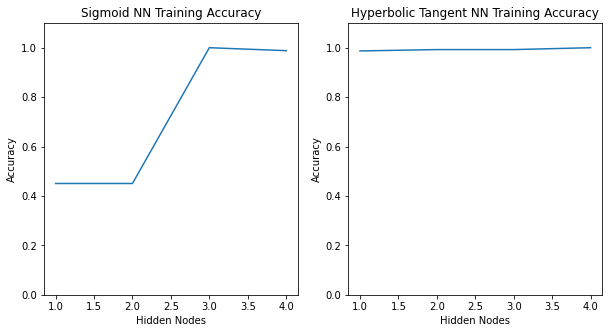

In [ ]:
import datetime
print(datetime.datetime.now())

#Params
epochs = 200
learnRate = 0.01
MaxNodes = 4 + 1

#Format our dataset
x = dataset.drop(columns=4)
x_normed = (x-x.mean())/x.std()
y = dataset[4]


# Divide data into train/test
x_train, x_test, y_train, y_test = train_test_split(x_normed, y, test_size=0.33, random_state=42)
x_train = np.append(np.ones((len(x_train),1)), x_train, axis=1)
x_test = np.append(np.ones((len(x_test),1)), x_test, axis=1)
y_train = np.array(y_train)
y_test = np.array(y_test)

#Store our accuracy results for plotting
accResults = [[] for i in range(len(generalNN.actType))]

for nnType in generalNN.actType:

  bestAccuracy = 0
  bestNodes = 0

  #Iterate through range of dimensions for hidden layer size
  for hid in reversed(range(1, MaxNodes)):

    #Initialize our NN
    model = generalNN(hid, len(x_train[0]), nnType)
    model.train(x_train, y_train, learnRate, epochs)

    #Test result on validation set
    acc = model.accuracy(x_train, y_train)
    accResults[nnType].append(acc)

    #Store our best number of nodes (accuracy cross-validation)
    if( acc > bestAccuracy ):
      bestAccuracy = acc
      bestNodes = hid


  #Now use the best number of nodes (based on accuracy cross-validation)
  model = generalNN(bestNodes, len(x_train[0]), nnType)
  model.train(x_train, y_train, learnRate, epochs)

  print("____BEST RESULT____")
  print(generalNN.actType[nnType], "using", bestNodes, "nodes")
  print("\tTest Set Accuracy:", model.accuracy(x_test, y_test), "\n")


#Plot our accuracy cross-validation results

def plotFunc(gs,title,xlabel=None,ylabel=None,xlim=None,ylim=None):
  ax = fig.add_subplot(gs)
  ax.set_title(title)
  ax.set_xlabel(xlabel)
  ax.set_ylabel(ylabel)

  if xlim is None and ylim is None:
    plt.autoscale(enable=True, axis='both', tight=False)
  elif xlim is None:
    ax.set_ylim(ylim)
    plt.autoscale(enable=True, axis='x', tight=False)
  elif ylim is None:
    ax.set_xlim(xlim)
    plt.autoscale(enable=True, axis='y', tight=False)
  else:
    ax.set_xlim(xlim)
    ax.set_ylim(ylim)

  return ax

x_axis = [i for i in reversed(range(1, MaxNodes))]

pprint(accResults,width=180)

fig = plt.figure(figsize=(10,5))
gs = gridspec.GridSpec(1,2)

ax = plotFunc(gs[0,0],generalNN.actType[0] + ' NN Training Accuracy','Hidden Nodes','Accuracy',None,(0,1.1))
ax.plot(x_axis, accResults[0])

ax = plotFunc(gs[0,1],generalNN.actType[1] + ' NN Training Accuracy','Hidden Nodes','Accuracy',None,(0,1.1))
ax.plot(x_axis, accResults[1])

